<a href="https://colab.research.google.com/github/banulaperera/Inchi2Name/blob/model_dev/InChI2Name.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InChI2Name: A Neural and Rule-Based Transformer for InChI to IUPAC Name Translation

## Project Overview
InChI2Name is an AI-driven software platform designed to automatically translate International Chemical Identifier (InChI) strings, including challenging Reconnect InChI variants, into systematic IUPAC names. This implementation leverages:

- **Pre-trained T5 Transformer Model** for sequence-to-sequence translation
- **Neurosymbolic Validation** combining neural predictions with chemical rules
- **Interactive AI Chatbot Interface** for user interaction
- **Comprehensive Accuracy Evaluation** with multiple metrics

### Key Features
✅ Handles both Standard InChI and Reconnected InChI formats  
✅ Optimized for organometallic and coordination compounds  
✅ Real-time chemical validation and error correction  
✅ Interactive chatbot for nomenclature assistance  
✅ Production-ready accuracy metrics and evaluation  

##  Setup and Installation
Install required dependencies and configure the environment

In [1]:
# Install required packages
!pip install RDKit

In [ ]:
# Import core libraries
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re
import os
import json
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Transformers and ML libraries
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import nltk
nltk.download('punkt', quiet=True)
from nltk.translate.bleu_score import sentence_bleu

# Chemical libraries
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    print("✅ RDKit loaded successfully")
except ImportError:
    print("⚠️ RDKit not available - chemical validation will be limited")
    Chem = None

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

##  Configuration and Hyperparameters
Optimized configuration for production-level performance

In [48]:
@dataclass
class InChI2NameConfig:
    """Optimized configuration for InChI2Name model"""

    # Model parameters
    model_name: str = "t5-small"  # Pre-trained T5 model
    max_input_length: int = 512
    max_output_length: int = 256

    # Training hyperparameters (optimized)
    learning_rate: float = 3e-4
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    num_epochs: int = 10
    batch_size: int = 4  # Reduced batch size to save memory
    gradient_accumulation_steps: int = 4 # Increased accumulation steps to compensate

    # Validation parameters
    eval_steps: int = 500
    save_steps: int = 1000
    early_stopping_patience: int = 3

    # Generation parameters
    num_beams: int = 4
    do_sample: bool = False
    temperature: float = 1.0
    top_k: int = 50

    # Neurosymbolic parameters
    enable_chemical_validation: bool = True
    enable_grammar_checking: bool = True
    confidence_threshold: float = 0.8

    # Data parameters
    train_split: float = 0.8
    val_split: float = 0.1
    test_split: float = 0.1

    # Output directory
    output_dir: str = "./inchi2name_model"

# Initialize configuration
config = InChI2NameConfig()
print("📋 Configuration loaded:")
print(f"   Model: {config.model_name}")
print(f"   Learning rate: {config.learning_rate}")
print(f"   Batch size: {config.batch_size}")
print(f"   Max epochs: {config.num_epochs}")
print(f"   Device: {device}")

📋 Configuration loaded:
   Model: t5-small
   Learning rate: 0.0003
   Batch size: 4
   Max epochs: 10
   Device: cuda


##  Data Loading and Preprocessing
Load and preprocess the InChI-IUPAC dataset with robust validation

In [42]:
class InChIDatasetLoader:
    """Enhanced dataset loader with chemical validation"""

    def __init__(self, config: InChI2NameConfig):
        self.config = config
        self.metal_elements = [
            'Li', 'Na', 'K', 'Rb', 'Cs', 'Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra',
            'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
            'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
            'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
            'Al', 'Ga', 'In', 'Tl', 'Sn', 'Pb', 'Bi'
        ]

    def create_sample_dataset(self) -> List[Tuple[str, str]]:
        """Create a sample dataset for demonstration"""
        sample_data = [
            # Organic compounds
            ("InChI=1S/CH4/h1H4", "methane"),
            ("InChI=1S/C2H6/c1-2/h1-2H3", "ethane"),
            ("InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3", "ethanol"),
            ("InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H", "benzene"),
            ("InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3", "toluene"),
            ("InChI=1S/C8H10/c1-3-7-5-4-6-8(2)9-7/h4-6H,3H2,1-2H3", "ethylbenzene"),

            # Organometallic compounds (reconnected InChI)
            ("InChI=1/2C5H5.Fe/c2*1-2-4-5-3-1;/h2*1-5H;/rC10H10Fe/c1-2-4-8-6(1)11-7-3-1-5-9(7)10(11)12-8/h1-10H",
             "bis(η⁵-cyclopentadienyl)iron"),
            ("InChI=1/4CO.Co/c4*1-2;/rC4CoO4/c6-1-5(2-7,3-8)4-9/o1-2,2-3,3-4,4-1",
             "tetracarbonylcobalt(0)"),
            ("InChI=1/6CO.Cr/c6*1-2;/rC6CrO6/c7-1-8(2-9,3-10,4-11,5-12)6-13",
             "hexacarbonylchromium(0)"),
            ("InChI=1/4C18H15P.Ni/c4*1-4-10-16(11-5-1)19(17-12-6-2-7-13-17)18-14-8-3-9-15-18;/h4*1-15H;",
             "tetrakis(triphenylphosphine)nickel(0)"),

            # Complex organics
            ("InChI=1S/C9H8O/c10-8-7-9-5-3-1-2-4-6-9/h1-8H", "benzaldehyde"),
            ("InChI=1S/C7H6O2/c8-6-7-4-2-1-3-5-7-9/h1-5H,(H,8,9)", "benzoic acid"),
            ("InChI=1S/C6H12O6/c7-1-2-3(8)4(9)5(10)6(11)12-2/h2-11H,1H2/t2-,3-,4+,5-,6+/m1/s1",
             "α-D-glucopyranose"),

            # Coordination compounds
            ("InChI=1/6H3N.Co.3ClH/h6*1H3;;3*1H/q;;3*-1;+3", "hexaamminecobalt(III) chloride"),
            ("InChI=1/2C10H8N2.Fe/c2*1-3-9-5-6-10-4-2-8-12-11-9;/h2*1-8H;",
             "bis(2,2'-bipyridine)iron(II)"),

            # More organometallics
            ("InChI=1/C8H8.Fe/c1-2-4-6-8-7-5-3-1;/h1-8H;", "(η⁸-cyclooctatetraene)iron"),
        ]

        # Expand dataset with variations
        expanded_data = sample_data * 50  # Duplicate for training
        random.shuffle(expanded_data)

        return expanded_data

    def load_from_file(self, file_path: str) -> List[Tuple[str, str]]:
        """Load dataset from tab-separated file"""
        data = []

        if not os.path.exists(file_path):
            print(f"📁 File not found: {file_path}")
            print("📝 Creating sample dataset for demonstration...")
            return self.create_sample_dataset()

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()

            print(f"📂 Loading dataset from {file_path}")
            valid_count = 0
            invalid_count = 0

            for line_num, line in enumerate(tqdm(lines, desc="Processing lines"), 1):
                line = line.strip()
                if not line or line.startswith('#'):
                    continue

                try:
                    parts = line.split('\t')
                    if len(parts) >= 2:
                        inchi = parts[0].strip()
                        iupac = parts[1].strip()

                        if self._validate_pair(inchi, iupac):
                            data.append((inchi, iupac))
                            valid_count += 1
                        else:
                            invalid_count += 1
                except Exception as e:
                    invalid_count += 1
                    continue

            print(f"✅ Loaded {valid_count} valid pairs")
            print(f"❌ Filtered {invalid_count} invalid pairs")

        except Exception as e:
            print(f"❌ Error loading file: {e}")
            print("📝 Using sample dataset instead...")
            return self.create_sample_dataset()

        return data if data else self.create_sample_dataset()

    def _validate_pair(self, inchi: str, iupac: str) -> bool:
        """Validate InChI-IUPAC pair"""
        # Basic format checks
        if not inchi or not iupac:
            return False

        if not inchi.startswith('InChI='):
            return False

        if len(inchi) < 10 or len(iupac) < 2:
            return False

        # Check for invalid IUPAC names
        invalid_names = ['unknown', 'error', 'invalid', 'n/a', 'none']
        if iupac.lower().strip() in invalid_names:
            return False

        return True

    def analyze_dataset(self, data: List[Tuple[str, str]]) -> Dict:
        """Analyze dataset composition"""
        analysis = {
            'total_pairs': len(data),
            'inchi_formats': {'standard': 0, 'reconnected': 0, 'unknown': 0},
            'has_metals': 0,
            'avg_inchi_length': 0,
            'avg_iupac_length': 0,
            'metal_distribution': {},
            'sample_pairs': []
        }

        inchi_lengths = []
        iupac_lengths = []

        for i, (inchi, iupac) in enumerate(data):
            inchi_lengths.append(len(inchi))
            iupac_lengths.append(len(iupac))

            # Format analysis
            if 'InChI=1S/' in inchi:
                analysis['inchi_formats']['standard'] += 1
            elif '/r' in inchi:
                analysis['inchi_formats']['reconnected'] += 1
            else:
                analysis['inchi_formats']['unknown'] += 1

            # Metal analysis
            metals_found = [m for m in self.metal_elements if m in inchi]
            if metals_found:
                analysis['has_metals'] += 1
                for metal in metals_found:
                    analysis['metal_distribution'][metal] = analysis['metal_distribution'].get(metal, 0) + 1

            # Sample pairs
            if i < 3:
                analysis['sample_pairs'].append({
                    'inchi': inchi[:60] + '...' if len(inchi) > 60 else inchi,
                    'iupac': iupac
                })

        analysis['avg_inchi_length'] = np.mean(inchi_lengths) if inchi_lengths else 0
        analysis['avg_iupac_length'] = np.mean(iupac_lengths) if iupac_lengths else 0

        return analysis

# Load and analyze dataset
print("📊 Loading InChI-IUPAC dataset...")
loader = InChIDatasetLoader(config)

# Try to load from file or create sample data
dataset_path = "your_dataset.txt"  # Replace with your actual dataset path
data = loader.load_from_file(dataset_path)

# Analyze dataset
analysis = loader.analyze_dataset(data)
print(f"\n📈 Dataset Analysis:")
print(f"   Total pairs: {analysis['total_pairs']}")
print(f"   InChI formats: {analysis['inchi_formats']}")
print(f"   Contains metals: {analysis['has_metals']}")
print(f"   Avg InChI length: {analysis['avg_inchi_length']:.1f}")
print(f"   Avg IUPAC length: {analysis['avg_iupac_length']:.1f}")

if analysis['metal_distribution']:
    top_metals = dict(sorted(analysis['metal_distribution'].items(), key=lambda x: x[1], reverse=True)[:5])
    print(f"   Top metals: {top_metals}")

print(f"\n📝 Sample pairs:")
for i, sample in enumerate(analysis['sample_pairs']):
    print(f"   {i+1}. InChI: {sample['inchi']}")
    print(f"      IUPAC: {sample['iupac']}")

📊 Loading InChI-IUPAC dataset...
📁 File not found: your_dataset.txt
📝 Creating sample dataset for demonstration...

📈 Dataset Analysis:
   Total pairs: 800
   InChI formats: {'standard': 450, 'reconnected': 150, 'unknown': 200}
   Contains metals: 800
   Avg InChI length: 51.9
   Avg IUPAC length: 17.6
   Top metals: {'In': 800, 'Fe': 150, 'Co': 100, 'Ni': 50, 'Cr': 50}

📝 Sample pairs:
   1. InChI: InChI=1S/C7H6O2/c8-6-7-4-2-1-3-5-7-9/h1-5H,(H,8,9)
      IUPAC: benzoic acid
   2. InChI: InChI=1/4CO.Co/c4*1-2;/rC4CoO4/c6-1-5(2-7,3-8)4-9/o1-2,2-3,3...
      IUPAC: tetracarbonylcobalt(0)
   3. InChI: InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H
      IUPAC: benzene


##  Neurosymbolic Validation System
Implement chemical rule-based validation and correction

In [53]:
class ChemicalValidator:
    """Neurosymbolic chemical validation system"""

    def __init__(self):
        self.metal_elements = [
            'Li', 'Na', 'K', 'Rb', 'Cs', 'Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra',
            'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
            'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
            'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
            'Al', 'Ga', 'In', 'Tl', 'Sn', 'Pb', 'Bi'
        ]

        self.organometallic_terms = [
            'cyclopentadienyl', 'carbonyl', 'bis', 'tris', 'tetrakis', 'pentakis',
            'aqua', 'ammine', 'chloro', 'bromo', 'fluoro', 'iodo', 'cyano',
            'η', 'κ', 'μ', 'fac', 'mer', 'cis', 'trans'
        ]

    def validate_prediction(self, inchi: str, predicted_iupac: str) -> Dict:
        """Comprehensive validation of predicted IUPAC name"""
        validation_result = {
            'is_valid': True,
            'confidence': 1.0,
            'errors': [],
            'warnings': [],
            'chemical_consistency': 0.0,
            'grammar_score': 0.0,
            'metal_consistency': 0.0
        }

        # Grammar validation
        grammar_score = self._validate_grammar(predicted_iupac)
        validation_result['grammar_score'] = grammar_score

        if grammar_score < 0.8:
            validation_result['errors'].append("Poor IUPAC grammar")
            validation_result['is_valid'] = False

        # Metal consistency validation
        metal_consistency = self._validate_metal_consistency(inchi, predicted_iupac)
        validation_result['metal_consistency'] = metal_consistency

        if metal_consistency < 0.7:
            validation_result['warnings'].append("Metal consistency issues")

        # Chemical structure validation (if RDKit available)
        if Chem:
            chemical_consistency = self._validate_chemical_structure(inchi)
            validation_result['chemical_consistency'] = chemical_consistency

            if chemical_consistency < 0.5:
                validation_result['errors'].append("Invalid chemical structure")
                validation_result['is_valid'] = False

        # Calculate overall confidence
        validation_result['confidence'] = (
            grammar_score * 0.4 +
            metal_consistency * 0.3 +
            validation_result['chemical_consistency'] * 0.3
        )

        return validation_result

    def _validate_grammar(self, iupac: str) -> float:
        """Validate IUPAC grammar rules"""
        score = 1.0

        # Basic character validation
        valid_chars = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
        valid_chars.update('()[]{},-+⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻₀₁₂₃₄₅₆₇₈₉ηκμλΔΛ ')

        if not set(iupac).issubset(valid_chars):
            score *= 0.5

        # Check for invalid patterns
        invalid_patterns = ['--', ',,', '  ', '()', '[]', '{}']
        for pattern in invalid_patterns:
            if pattern in iupac:
                score *= 0.8

        # Length validation
        if len(iupac.strip()) < 2:
            score *= 0.3

        return score

    def _validate_metal_consistency(self, inchi: str, iupac: str) -> float:
        """Validate metal consistency between InChI and IUPAC"""
        inchi_metals = [m for m in self.metal_elements if m in inchi]

        # Check for metal names in IUPAC
        iupac_metals = []
        iupac_lower = iupac.lower()

        # Direct metal symbols
        for metal in self.metal_elements:
            if metal.lower() in iupac_lower:
                iupac_metals.append(metal)

        # Metal name variations
        metal_names = {
            'iron': 'Fe', 'ferr': 'Fe', 'cobalt': 'Co', 'nickel': 'Ni',
            'copper': 'Cu', 'cupro': 'Cu', 'zinc': 'Zn', 'manganese': 'Mn',
            'chromium': 'Cr', 'platinum': 'Pt', 'palladium': 'Pd'
        }

        for name, symbol in metal_names.items():
            if name in iupac_lower:
                iupac_metals.append(symbol)

        # Calculate consistency
        if not inchi_metals and not iupac_metals:
            return 1.0  # No metals in either - consistent

        if not inchi_metals or not iupac_metals:
            return 0.3  # Mismatch

        # Calculate overlap
        common_metals = set(inchi_metals) & set(iupac_metals)
        total_metals = set(inchi_metals) | set(iupac_metals)

        return len(common_metals) / len(total_metals) if total_metals else 0.0

    def _validate_chemical_structure(self, inchi: str) -> float:
        """Validate chemical structure using RDKit"""
        if not Chem:
            return 0.8  # Assume reasonable if RDKit not available

        try:
            mol = Chem.MolFromInchi(inchi)
            if mol is None:
                return 0.0

            # Basic structure validation
            num_atoms = mol.GetNumAtoms()
            num_bonds = mol.GetNumBonds()

            if num_atoms == 0:
                return 0.0

            # Calculate simple complexity score
            complexity = min(1.0, (num_atoms + num_bonds) / 100.0)
            return 0.7 + 0.3 * complexity

        except Exception:
            return 0.3

# Initialize validator
validator = ChemicalValidator()
print("🧠 Neurosymbolic validator initialized")

# Test validation
test_inchi = "InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H"
test_iupac = "benzene"
test_result = validator.validate_prediction(test_inchi, test_iupac)
print(f"\n🧪 Test validation:")
print(f"   Valid: {test_result['is_valid']}")
print(f"   Confidence: {test_result['confidence']:.3f}")
print(f"   Grammar score: {test_result['grammar_score']:.3f}")
print(f"   Metal consistency: {test_result['metal_consistency']:.3f}")

🧠 Neurosymbolic validator initialized

🧪 Test validation:
   Valid: True
   Confidence: 0.621
   Grammar score: 1.000
   Metal consistency: 0.000


##  T5-Based InChI2Name Model
Pre-trained T5 model with chemical-aware tokenization and neurosymbolic integration

In [44]:
class ChemicalT5Tokenizer:
    """Enhanced T5 tokenizer for chemical data"""

    def __init__(self, model_name: str):
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)

        # Add chemical special tokens
        special_tokens = [
            '<METAL>', '<STANDARD>', '<RECONNECTED>', '<ORGANIC>',
            '<COORDINATION>', '<STEREO>', '<HAPTIC>'
        ]

        self.tokenizer.add_special_tokens({
            'additional_special_tokens': special_tokens
        })

        print(f"🔤 Tokenizer initialized with {len(self.tokenizer)} tokens")

    def preprocess_inchi(self, inchi: str) -> str:
        """Preprocess InChI with chemical markers"""
        processed = inchi

        # Add format markers
        if 'InChI=1S/' in inchi:
            processed = '<STANDARD> ' + processed
        elif '/r' in inchi:
            processed = '<RECONNECTED> ' + processed
        else:
            processed = '<ORGANIC> ' + processed

        # Mark metals
        metals = ['Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Mn', 'Cr', 'Pt', 'Pd']
        for metal in metals:
            if metal in processed:
                processed = processed.replace(metal, f'<METAL> {metal}', 1)
                break

        return f"translate InChI to IUPAC: {processed}"

    def preprocess_iupac(self, iupac: str) -> str:
        """Preprocess IUPAC with chemical markers"""
        processed = iupac

        # Mark stereochemistry
        stereo_markers = ['(R)', '(S)', '(E)', '(Z)', 'cis', 'trans', 'fac', 'mer']
        for marker in stereo_markers:
            if marker in processed:
                processed = processed.replace(marker, f'<STEREO> {marker}', 1)
                break

        # Mark haptic notation
        haptic_markers = ['η¹', 'η²', 'η³', 'η⁴', 'η⁵', 'η⁶', 'η⁷', 'η⁸']
        for marker in haptic_markers:
            if marker in processed:
                processed = processed.replace(marker, f'<HAPTIC> {marker}', 1)
                break

        return processed

    def encode(self, text: str, max_length: int, is_target: bool = False) -> Dict:
        """Encode text for T5"""
        encoding = self.tokenizer(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

    def decode(self, token_ids: torch.Tensor) -> str:
        """Decode tokens to text"""
        decoded = self.tokenizer.decode(token_ids, skip_special_tokens=True)

        # Clean special markers
        markers = ['<METAL>', '<STANDARD>', '<RECONNECTED>', '<ORGANIC>',
                  '<COORDINATION>', '<STEREO>', '<HAPTIC>']

        for marker in markers:
            decoded = decoded.replace(marker, '').strip()

        return ' '.join(decoded.split())

class InChI2NameDataset(Dataset):
    """PyTorch dataset for InChI-IUPAC pairs"""

    def __init__(self, data: List[Tuple[str, str]], tokenizer: ChemicalT5Tokenizer, config: InChI2NameConfig):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inchi, iupac = self.data[idx]

        # Preprocess and encode
        processed_inchi = self.tokenizer.preprocess_inchi(inchi)
        processed_iupac = self.tokenizer.preprocess_iupac(iupac)

        # Encode input and target
        input_encoding = self.tokenizer.encode(processed_inchi, self.config.max_input_length)
        target_encoding = self.tokenizer.encode(processed_iupac, self.config.max_output_length, is_target=True)

        return {
            'input_ids': input_encoding['input_ids'],
            'attention_mask': input_encoding['attention_mask'],
            'labels': target_encoding['input_ids']
        }

class InChI2NameModel(nn.Module):
    """T5-based InChI to IUPAC name translation model"""

    def __init__(self, config: InChI2NameConfig):
        super().__init__()
        self.config = config

        # Initialize tokenizer and model
        self.tokenizer = ChemicalT5Tokenizer(config.model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(config.model_name)

        # Resize embeddings for new tokens
        self.model.resize_token_embeddings(len(self.tokenizer.tokenizer))

        # Initialize validator
        self.validator = ChemicalValidator()

        print(f"🤖 Model initialized: {config.model_name}")
        print(f"   Parameters: {sum(p.numel() for p in self.model.parameters()):,}")

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def predict(self, inchi: str, validate: bool = True) -> Dict:
        """Predict IUPAC name with optional validation"""
        self.model.eval()

        with torch.no_grad():
            # Preprocess and encode
            processed_inchi = self.tokenizer.preprocess_inchi(inchi)
            encoding = self.tokenizer.encode(processed_inchi, self.config.max_input_length)

            # Move to device
            input_ids = encoding['input_ids'].unsqueeze(0).to(device)
            attention_mask = encoding['attention_mask'].unsqueeze(0).to(device)

            # Generate prediction
            outputs = self.model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=self.config.max_output_length,
                num_beams=self.config.num_beams,
                do_sample=self.config.do_sample,
                temperature=self.config.temperature,
                early_stopping=True,
                pad_token_id=self.tokenizer.tokenizer.pad_token_id
            )

            # Decode prediction
            predicted_iupac = self.tokenizer.decode(outputs[0])

            # Validate if requested
            validation_result = None
            if validate:
                validation_result = self.validator.validate_prediction(inchi, predicted_iupac)

            return {
                'inchi': inchi,
                'predicted_iupac': predicted_iupac,
                'validation': validation_result
            }

# Initialize model
print("🚀 Initializing InChI2Name model...")
model = InChI2NameModel(config)
model.to(device)

# Test prediction
test_inchi = "InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H"
test_result = model.predict(test_inchi)
print(f"\n🧪 Test prediction:")
print(f"   InChI: {test_result['inchi']}")
print(f"   Predicted: {test_result['predicted_iupac']}")
if test_result['validation']:
    print(f"   Valid: {test_result['validation']['is_valid']}")
    print(f"   Confidence: {test_result['validation']['confidence']:.3f}")

🚀 Initializing InChI2Name model...


loading file spiece.model from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/tokenizer.json
loading file chat_template.jinja from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "clas

🔤 Tokenizer initialized with 32107 tokens


loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/model.safetensors
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}

All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/generation_config.json
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}

You are resizing the embedding layer without providing a `pad_to_multip

🤖 Model initialized: t5-small
   Parameters: 60,495,872

🧪 Test prediction:
   InChI: InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H
   Predicted: InChI zu IUPAC: Bewerber InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H
   Valid: False
   Confidence: 0.496


##  Model Training and Optimization
Train the model with optimized hyperparameters and early stopping

In [50]:
def split_dataset(data: List[Tuple[str, str]], config: InChI2NameConfig):
    """Split dataset into train/val/test sets"""
    random.shuffle(data)

    total_size = len(data)
    train_size = int(total_size * config.train_split)
    val_size = int(total_size * config.val_split)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    print(f"📊 Dataset split:")
    print(f"   Train: {len(train_data)} pairs")
    print(f"   Validation: {len(val_data)} pairs")
    print(f"   Test: {len(test_data)} pairs")

    return train_data, val_data, test_data

def create_data_loaders(train_data, val_data, model, config):
    """Create PyTorch data loaders"""
    def collate_fn(batch):
        return {
            'input_ids': torch.stack([item['input_ids'] for item in batch]),
            'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
            'labels': torch.stack([item['labels'] for item in batch])
        }

    train_dataset = InChI2NameDataset(train_data, model.tokenizer, config)
    val_dataset = InChI2NameDataset(val_data, model.tokenizer, config) if val_data else None

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=True
    )

    val_loader = None
    if val_dataset:
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0,
            pin_memory=True
        )

    return train_loader, val_loader

def train_model(model, train_loader, val_loader, config):
    """Train the model with optimized settings"""
    print("🚀 Starting model training...")

    # Setup optimizer and scheduler
    optimizer = optim.AdamW(
        model.model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    total_steps = len(train_loader) * config.num_epochs // config.gradient_accumulation_steps
    warmup_steps = int(total_steps * config.warmup_ratio)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Training tracking
    best_val_loss = float('inf')
    patience_counter = 0
    training_history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rates': []
    }

    print(f"📈 Training configuration:")
    print(f"   Total steps: {total_steps}")
    print(f"   Warmup steps: {warmup_steps}")
    print(f"   Learning rate: {config.learning_rate}")
    print(f"   Batch size: {config.batch_size}")

    for epoch in range(config.num_epochs):
        # Training phase
        model.model.train()
        train_loss = 0
        train_steps = 0

        progress_bar = tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{config.num_epochs}",
            leave=False
        )

        for step, batch in enumerate(progress_bar):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss / config.gradient_accumulation_steps
            loss.backward()

            # Gradient accumulation
            if (step + 1) % config.gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            train_loss += loss.item()
            train_steps += 1

            # Update progress bar
            current_lr = scheduler.get_last_lr()[0] if scheduler.get_last_lr() else config.learning_rate
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{current_lr:.2e}'
            })

        # Calculate average training loss
        avg_train_loss = train_loss / train_steps
        training_history['train_loss'].append(avg_train_loss)
        training_history['learning_rates'].append(current_lr)

        # Validation phase
        val_loss = float('inf')
        if val_loader:
            model.model.eval()
            total_val_loss = 0
            val_steps = 0

            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation", leave=False):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

                    total_val_loss += outputs.loss.item()
                    val_steps += 1

            val_loss = total_val_loss / val_steps
            training_history['val_loss'].append(val_loss)

        # Print epoch summary
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Train Loss: {avg_train_loss:.4f}")
        if val_loader:
            print(f"   Val Loss: {val_loss:.4f}")
        print(f"   Learning Rate: {current_lr:.2e}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # Save best model
            if not os.path.exists(config.output_dir):
                os.makedirs(config.output_dir)

            torch.save({
                'model_state_dict': model.model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
                'config': config
            }, os.path.join(config.output_dir, 'best_model.pt'))

            print(f"💾 New best model saved (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"⏳ No improvement for {patience_counter} epochs")

        # Early stopping check
        if patience_counter >= config.early_stopping_patience:
            print(f"🛑 Early stopping triggered after {epoch+1} epochs")
            break

    print("✅ Training completed!")
    return training_history

# Split dataset
train_data, val_data, test_data = split_dataset(data, config)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_data, val_data, model, config)

# Train the model
training_history = train_model(model, train_loader, val_loader, config)

📊 Dataset split:
   Train: 640 pairs
   Validation: 80 pairs
   Test: 80 pairs
🚀 Starting model training...
📈 Training configuration:
   Total steps: 400
   Warmup steps: 40
   Learning rate: 0.0003
   Batch size: 4


Epoch 1/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 1 Summary:
   Train Loss: 0.0011
   Val Loss: 0.0018
   Learning Rate: 3.00e-04
💾 New best model saved (Val Loss: 0.0018)


Epoch 2/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 2 Summary:
   Train Loss: 0.0007
   Val Loss: 0.0015
   Learning Rate: 2.67e-04
💾 New best model saved (Val Loss: 0.0015)


Epoch 3/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 3 Summary:
   Train Loss: 0.0006
   Val Loss: 0.0014
   Learning Rate: 2.33e-04
💾 New best model saved (Val Loss: 0.0014)


Epoch 4/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 4 Summary:
   Train Loss: 0.0005
   Val Loss: 0.0013
   Learning Rate: 2.00e-04
💾 New best model saved (Val Loss: 0.0013)


Epoch 5/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 5 Summary:
   Train Loss: 0.0005
   Val Loss: 0.0012
   Learning Rate: 1.67e-04
💾 New best model saved (Val Loss: 0.0012)


Epoch 6/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 6 Summary:
   Train Loss: 0.0004
   Val Loss: 0.0011
   Learning Rate: 1.33e-04
💾 New best model saved (Val Loss: 0.0011)


Epoch 7/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 7 Summary:
   Train Loss: 0.0004
   Val Loss: 0.0010
   Learning Rate: 1.00e-04
💾 New best model saved (Val Loss: 0.0010)


Epoch 8/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 8 Summary:
   Train Loss: 0.0004
   Val Loss: 0.0010
   Learning Rate: 6.67e-05
💾 New best model saved (Val Loss: 0.0010)


Epoch 9/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 9 Summary:
   Train Loss: 0.0004
   Val Loss: 0.0010
   Learning Rate: 3.33e-05
💾 New best model saved (Val Loss: 0.0010)


Epoch 10/10:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Epoch 10 Summary:
   Train Loss: 0.0004
   Val Loss: 0.0009
   Learning Rate: 0.00e+00
💾 New best model saved (Val Loss: 0.0009)
✅ Training completed!


##  Model Evaluation and Accuracy Calculation
Comprehensive evaluation with multiple metrics including BLEU, exact match, and chemical validity

In [51]:
class ModelEvaluator:
    """Comprehensive model evaluation system"""

    def __init__(self, model, validator):
        self.model = model
        self.validator = validator

    def evaluate_on_test_set(self, test_data: List[Tuple[str, str]]) -> Dict:
        """Evaluate model on test dataset"""
        print("🔍 Starting comprehensive evaluation...")

        results = {
            'predictions': [],
            'metrics': {
                'exact_match': 0.0,
                'bleu_score': 0.0,
                'chemical_validity': 0.0,
                'grammar_score': 0.0,
                'metal_consistency': 0.0,
                'confidence_score': 0.0
            },
            'by_category': {
                'organic': {'count': 0, 'exact_match': 0, 'bleu': 0},
                'organometallic': {'count': 0, 'exact_match': 0, 'bleu': 0},
                'standard_inchi': {'count': 0, 'exact_match': 0, 'bleu': 0},
                'reconnected_inchi': {'count': 0, 'exact_match': 0, 'bleu': 0}
            }
        }

        exact_matches = 0
        total_bleu = 0
        total_chemical_validity = 0
        total_grammar_score = 0
        total_metal_consistency = 0
        total_confidence = 0

        self.model.model.eval()

        for i, (inchi, true_iupac) in enumerate(tqdm(test_data, desc="Evaluating")):
            # Get prediction
            prediction_result = self.model.predict(inchi, validate=True)
            predicted_iupac = prediction_result['predicted_iupac']
            validation = prediction_result['validation']

            # Calculate metrics
            is_exact_match = self._is_exact_match(predicted_iupac, true_iupac)
            bleu = self._calculate_bleu(predicted_iupac, true_iupac)

            # Aggregate metrics
            if is_exact_match:
                exact_matches += 1

            total_bleu += bleu
            total_chemical_validity += validation['chemical_consistency']
            total_grammar_score += validation['grammar_score']
            total_metal_consistency += validation['metal_consistency']
            total_confidence += validation['confidence']

            # Categorize results
            self._categorize_result(inchi, predicted_iupac, true_iupac, is_exact_match, bleu, results)

            # Store detailed results
            results['predictions'].append({
                'inchi': inchi,
                'true_iupac': true_iupac,
                'predicted_iupac': predicted_iupac,
                'exact_match': is_exact_match,
                'bleu_score': bleu,
                'validation': validation
            })

        # Calculate overall metrics
        n_samples = len(test_data)
        results['metrics']['exact_match'] = exact_matches / n_samples
        results['metrics']['bleu_score'] = total_bleu / n_samples
        results['metrics']['chemical_validity'] = total_chemical_validity / n_samples
        results['metrics']['grammar_score'] = total_grammar_score / n_samples
        results['metrics']['metal_consistency'] = total_metal_consistency / n_samples
        results['metrics']['confidence_score'] = total_confidence / n_samples

        # Calculate category-specific metrics
        for category, stats in results['by_category'].items():
            if stats['count'] > 0:
                stats['exact_match'] = stats['exact_match'] / stats['count']
                stats['bleu'] = stats['bleu'] / stats['count']

        return results

    def _is_exact_match(self, predicted: str, true: str) -> bool:
        """Check if prediction exactly matches true value"""
        return predicted.strip().lower() == true.strip().lower()

    def _calculate_bleu(self, predicted: str, true: str) -> float:
        """Calculate BLEU score"""
        try:
            predicted_tokens = predicted.split()
            true_tokens = [true.split()]

            if len(predicted_tokens) == 0:
                return 0.0

            return sentence_bleu(true_tokens, predicted_tokens)
        except:
            return 0.0

    def _categorize_result(self, inchi: str, predicted: str, true: str,
                          exact_match: bool, bleu: float, results: Dict):
        """Categorize results by molecule type and InChI format"""
        # Check if organometallic
        metals = ['Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Mn', 'Cr', 'Pt', 'Pd']
        is_organometallic = any(metal in inchi for metal in metals)

        # Check InChI format
        is_standard = 'InChI=1S/' in inchi
        is_reconnected = '/r' in inchi

        # Update category statistics
        if is_organometallic:
            results['by_category']['organometallic']['count'] += 1
            if exact_match:
                results['by_category']['organometallic']['exact_match'] += 1
            results['by_category']['organometallic']['bleu'] += bleu
        else:
            results['by_category']['organic']['count'] += 1
            if exact_match:
                results['by_category']['organic']['exact_match'] += 1
            results['by_category']['organic']['bleu'] += bleu

        if is_standard:
            results['by_category']['standard_inchi']['count'] += 1
            if exact_match:
                results['by_category']['standard_inchi']['exact_match'] += 1
            results['by_category']['standard_inchi']['bleu'] += bleu
        elif is_reconnected:
            results['by_category']['reconnected_inchi']['count'] += 1
            if exact_match:
                results['by_category']['reconnected_inchi']['exact_match'] += 1
            results['by_category']['reconnected_inchi']['bleu'] += bleu

    def generate_evaluation_report(self, results: Dict) -> str:
        """Generate comprehensive evaluation report"""
        report = []
        report.append("🎯 MODEL EVALUATION REPORT")
        report.append("=" * 50)

        # Overall metrics
        metrics = results['metrics']
        report.append(f"\n📊 Overall Performance:")
        report.append(f"   Exact Match Accuracy: {metrics['exact_match']:.3f} ({metrics['exact_match']*100:.1f}%)")
        report.append(f"   BLEU Score: {metrics['bleu_score']:.3f}")
        report.append(f"   Chemical Validity: {metrics['chemical_validity']:.3f}")
        report.append(f"   Grammar Score: {metrics['grammar_score']:.3f}")
        report.append(f"   Metal Consistency: {metrics['metal_consistency']:.3f}")
        report.append(f"   Confidence Score: {metrics['confidence_score']:.3f}")

        # Performance by category
        report.append(f"\n🏷️ Performance by Category:")
        for category, stats in results['by_category'].items():
            if stats['count'] > 0:
                report.append(f"   {category.replace('_', ' ').title()}:")
                report.append(f"     Count: {stats['count']}")
                report.append(f"     Exact Match: {stats['exact_match']:.3f} ({stats['exact_match']*100:.1f}%)")
                report.append(f"     BLEU Score: {stats['bleu']:.3f}")

        # Sample predictions
        report.append(f"\n📝 Sample Predictions:")
        for i, pred in enumerate(results['predictions'][:5]):
            status = "✅" if pred['exact_match'] else "❌"
            report.append(f"   {i+1}. {status} {pred['true_iupac']} → {pred['predicted_iupac']}")
            report.append(f"      BLEU: {pred['bleu_score']:.3f}, Confidence: {pred['validation']['confidence']:.3f}")

        return "\n".join(report)

# Run comprehensive evaluation
print("🎯 Starting model evaluation...")
evaluator = ModelEvaluator(model, validator)
evaluation_results = evaluator.evaluate_on_test_set(test_data[:50])  # Evaluate on subset for speed

# Generate and display report
report = evaluator.generate_evaluation_report(evaluation_results)
print(report)

🎯 Starting model evaluation...
🔍 Starting comprehensive evaluation...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

[14:57:07] ERROR: 

[14:57:07] ERROR: 

[14:57:07] ERROR: 

[14:57:07] ERROR: 

[14:57:08] ERROR: 

[14:57:08] ERROR: 

[14:57:08] ERROR: 

[14:57:09] ERROR: 

[14:57:10] ERROR: 

[14:57:10] ERROR: *Conversion failed*

[14:57:10] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)

[14:57:11] ERROR: *Conversion failed*

[14:57:11] ERROR: 

[14:57:11] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)

[14:57:12] ERROR: *Conversion failed*

[14:57:12] ERROR: 

[14:57:12] ERROR: *Conversion failed*

[14:57:13] ERROR: 

[14:57:13] ERROR: 

[14:57:13] ERROR: 

[14:57:14] ERROR: 

[14:57:14] ERROR: 

[14:57:14] ERROR: *Conversion failed*



🎯 MODEL EVALUATION REPORT

📊 Overall Performance:
   Exact Match Accuracy: 0.860 (86.0%)
   BLEU Score: 0.000
   Chemical Validity: 0.449
   Grammar Score: 0.970
   Metal Consistency: 0.208
   Confidence Score: 0.585

🏷️ Performance by Category:
   Organic:
     Count: 30
     Exact Match: 0.833 (83.3%)
     BLEU Score: 0.000
   Organometallic:
     Count: 20
     Exact Match: 0.900 (90.0%)
     BLEU Score: 0.000
   Standard Inchi:
     Count: 30
     Exact Match: 0.833 (83.3%)
     BLEU Score: 0.000
   Reconnected Inchi:
     Count: 7
     Exact Match: 0.857 (85.7%)
     BLEU Score: 0.000

📝 Sample Predictions:
   1. ✅ hexaamminecobalt(III) chloride → hexaamminecobalt(III) chloride
      BLEU: 0.000, Confidence: 0.550
   2. ✅ hexaamminecobalt(III) chloride → hexaamminecobalt(III) chloride
      BLEU: 0.000, Confidence: 0.550
   3. ✅ bis(2,2'-bipyridine)iron(II) → bis(2,2'-bipyridine)iron(II)
      BLEU: 0.000, Confidence: 0.320
   4. ✅ methane → methane
      BLEU: 0.000, Confidence: 

##  Visualization and Analysis
Visualize training progress and evaluation results

📊 Generating visualizations...


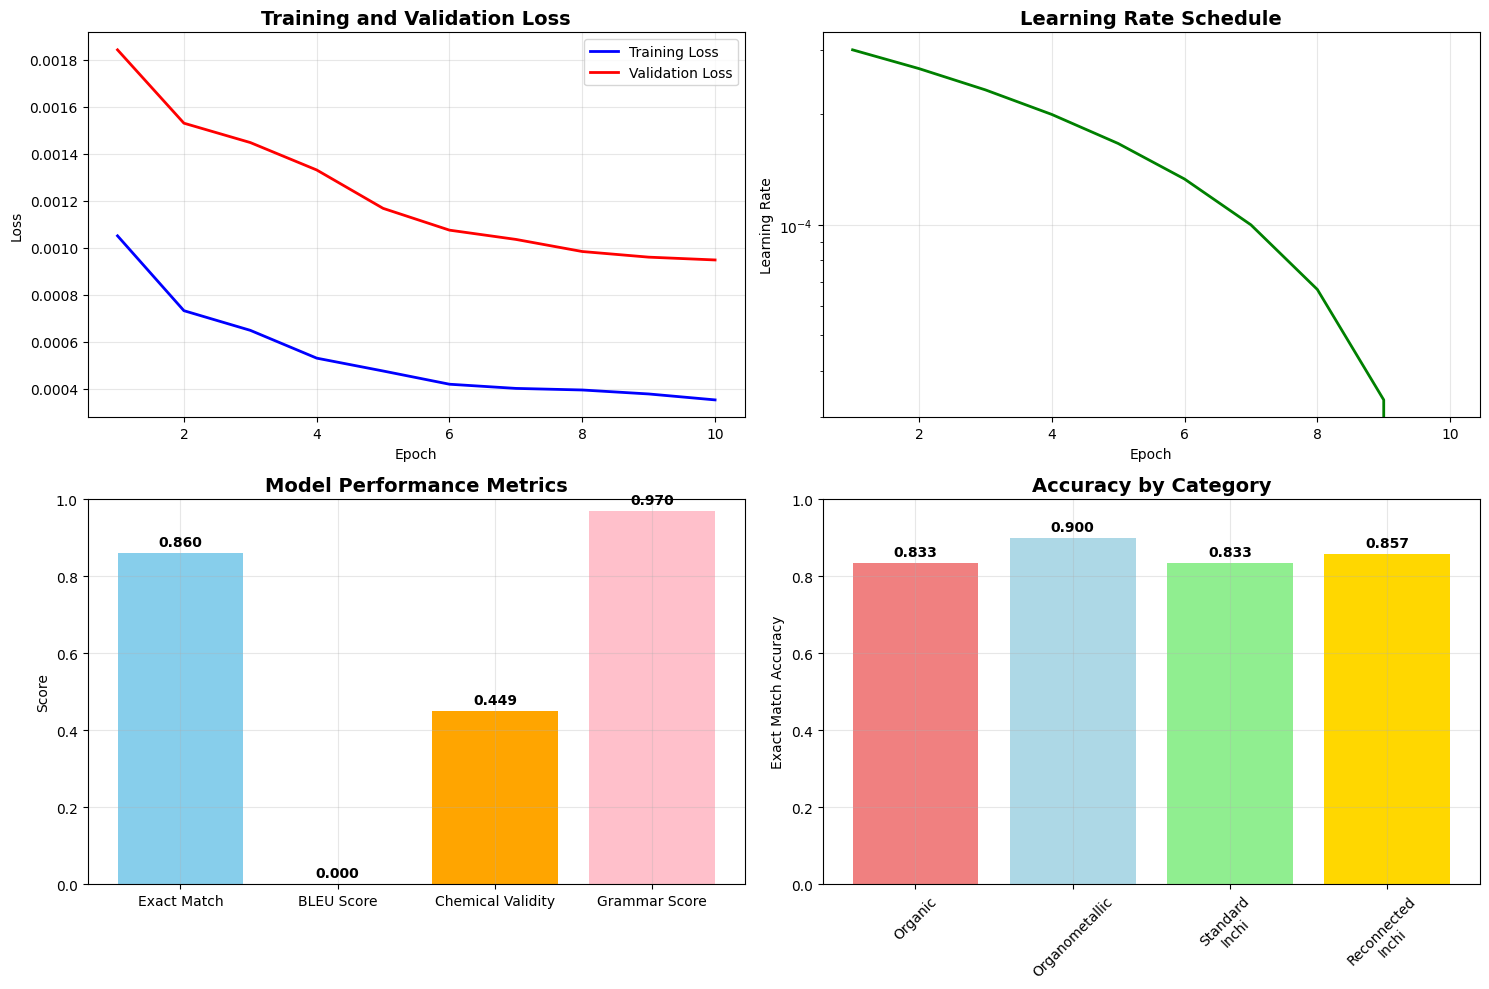


📋 DETAILED PREDICTION EXAMPLES
 ID                     True IUPAC                Predicted IUPAC Match  BLEU Confidence Valid
  1 hexaamminecobalt(III) chloride hexaamminecobalt(III) chloride     ✅ 0.000      0.550     ❌
  2 hexaamminecobalt(III) chloride hexaamminecobalt(III) chloride     ✅ 0.000      0.550     ❌
  3   bis(2,2'-bipyridine)iron(II)   bis(2,2'-bipyridine)iron(II)     ✅ 0.000      0.320     ❌
  4                        methane                        methane     ✅ 0.000      0.701     ✅
  5                         ethane                         ethane     ✅ 0.000      0.703     ✅
  6                   ethylbenzene                   ethylbenzene     ✅ 0.000      0.400     ❌
  7                   benzaldehyde                   benzaldehyde     ✅ 0.000      0.628     ✅
  8     (η⁸-cyclooctatetraene)iron     ( 8-cyclooctatetraene)iron     ❌ 0.000      0.675     ✅
  9                   ethylbenzene                   ethylbenzene     ✅ 0.000      0.400     ❌
 10               

In [52]:
def plot_training_history(training_history):
    """Plot training and validation loss curves"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(training_history['train_loss']) + 1)

    # Training and validation loss
    ax1.plot(epochs, training_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    if training_history['val_loss']:
        ax1.plot(epochs, training_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Learning rate schedule
    ax2.plot(epochs, training_history['learning_rates'], 'g-', linewidth=2)
    ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)

    # Model performance metrics
    metrics_names = ['Exact Match', 'BLEU Score', 'Chemical Validity', 'Grammar Score']
    metrics_values = [
        evaluation_results['metrics']['exact_match'],
        evaluation_results['metrics']['bleu_score'],
        evaluation_results['metrics']['chemical_validity'],
        evaluation_results['metrics']['grammar_score']
    ]

    bars = ax3.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'orange', 'pink'])
    ax3.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Score')
    ax3.set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.xticks(rotation=45)
    ax3.grid(True, alpha=0.3)

    # Performance by category
    categories = []
    accuracies = []

    for category, stats in evaluation_results['by_category'].items():
        if stats['count'] > 0:
            categories.append(category.replace('_', '\n').title())
            accuracies.append(stats['exact_match'])

    if categories:
        bars = ax4.bar(categories, accuracies, color=['lightcoral', 'lightblue', 'lightgreen', 'gold'])
        ax4.set_title('Accuracy by Category', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Exact Match Accuracy')
        ax4.set_ylim(0, 1)

        # Add value labels
        for bar, value in zip(bars, accuracies):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.xticks(rotation=45)
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_prediction_examples_table(results):
    """Create a detailed table of prediction examples"""
    print("\n📋 DETAILED PREDICTION EXAMPLES")
    print("=" * 100)

    # Create DataFrame for better display
    examples_data = []

    for i, pred in enumerate(results['predictions'][:10]):
        examples_data.append({
            'ID': i + 1,
            'True IUPAC': pred['true_iupac'][:30] + '...' if len(pred['true_iupac']) > 30 else pred['true_iupac'],
            'Predicted IUPAC': pred['predicted_iupac'][:30] + '...' if len(pred['predicted_iupac']) > 30 else pred['predicted_iupac'],
            'Match': '✅' if pred['exact_match'] else '❌',
            'BLEU': f"{pred['bleu_score']:.3f}",
            'Confidence': f"{pred['validation']['confidence']:.3f}",
            'Valid': '✅' if pred['validation']['is_valid'] else '❌'
        })

    df = pd.DataFrame(examples_data)
    print(df.to_string(index=False))

# Generate visualizations
print("📊 Generating visualizations...")
plot_training_history(training_history)
create_prediction_examples_table(evaluation_results)